In [ ]:
!pip install s3fs

In [41]:
# access data from Google Drive directory
from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/My Drive/'

# import libraries
import pandas as pd
import xarray as xr
import numpy as np
import pandas as pd
import s3fs
import fsspec
import matplotlib.pyplot as plt
from datetime import datetime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 1: Mean risk of frost and freeze for months of Oct to Jan for period of 1991-2020

In [69]:
def get_octjan_temp_stats(ghcn_id='USW00023188',
                          start_yr=1991,
                          end_yr=2020):
    '''
    Calculates daily temperature min of any GHCN weather station for desired range of N years
    '''

    # import daily station data
    df = pd.read_parquet(
        "s3://noaa-ghcn-pds/parquet/by_station/STATION=" + ghcn_id + "/",
        storage_options={"anon": True})  # passed to `s3fs.S3FileSystem`

    # create date index and MMDD (month-day) column
    df['DATE'] = pd.to_datetime(df['DATE'].apply(
        lambda x: datetime.strptime(x, '%Y%m%d')))
    df = df.set_index('DATE').sort_index()

    # create Day, Month, Year columns for grouping
    df['Day'] = df.index.day
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    # apply unit correction of DATA_VALUE column for temps
    df['DATA_VALUE'] = df['DATA_VALUE'] / 10

    # subset desired months of Oct to Jan
    df = df[(df.Month.isin([10, 11, 12, 1])) & \
            (df.index.year >= start_yr) & (df.index.year <= end_yr)]

    # create dataframe for station min temps
    min_temps = df[df['ELEMENT'].isin(['TMIN'])]

    return min_temps


In [74]:
# get Plant City temp mins for Oct to Jan for 1991-2020
frost_min_temp_stats = \
get_octjan_temp_stats(ghcn_id='USC00087205',
                      start_yr=1991,
                      end_yr=2020)

freeze_min_temp_stats = \
get_octjan_temp_stats(ghcn_id='USC00087205',
                      start_yr=1991,
                      end_yr=2020)

In [76]:
# Celsius to Fahr conversion
def CtoF(celsius):
    return (celsius * 9/5) + 32

######## FROST ########
frost_min_temp_stats['tmin_f'] = CtoF(frost_min_temp_stats['DATA_VALUE'])
# determine which days meet frost conditions
frost_min_temp_stats['frost_occurs'] = (frost_min_temp_stats['tmin_f'] <= 32)
# calculate mean number of days per month when frost temps occur (<32 F)
frost_risk = frost_min_temp_stats.groupby(
    ['Month', 'Year']).mean('frost_occurs')
frost_risk = frost_risk.rename(columns={'frost_occurs': 'monthly_frost_risk'})
# compute mean monthly frost risk for all years 1991-2020
month_annual_frost_risk = frost_risk.groupby('Month').mean('monthly_frost_risk')
# print final results
print(month_annual_frost_risk)

######## FREEZE ########
freeze_min_temp_stats['tmin_f'] = CtoF(freeze_min_temp_stats['DATA_VALUE'])
# determine which days meet freeze conditions
freeze_min_temp_stats['freeze_occurs'] = (freeze_min_temp_stats['tmin_f'] <= 28)
# calculate mean number of days per month when frost temps occur (<28 F)
freeze_risk = freeze_min_temp_stats.groupby(
    ['Month', 'Year']).mean('freeze_occurs')
freeze_risk = freeze_risk.rename(
    columns={'freeze_occurs': 'monthly_freeze_risk'})
# compute mean monthly freeze risk for all years 1991-2020
month_annual_freeze_risk =\
 freeze_risk.groupby('Month').mean('monthly_freeze_risk')

# display final results
print(month_annual_freeze_risk)

       DATA_VALUE        Day     tmin_f  monthly_frost_risk
Month                                                      
1        9.924069  16.010769  49.863325            0.060744
10      18.812803  15.970217  65.863045            0.000000
11      14.275031  15.509395  57.695056            0.001111
12      11.712350  15.934935  53.082230            0.019427
       DATA_VALUE        Day     tmin_f  monthly_freeze_risk
Month                                                       
1        9.924069  16.010769  49.863325             0.016308
10      18.812803  15.970217  65.863045             0.000000
11      14.275031  15.509395  57.695056             0.000000
12      11.712350  15.934935  53.082230             0.005376


# Part 2: Correlation between Freeze Risk and ENSO indices

In [80]:
# import ENSO data to pandas df
enso = pd.read_csv(
    'https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices',
    sep='\s+')
# subset relevant months and years
enso = enso[enso.MON.isin([10, 11, 12, 1]) & \
            enso.YR.isin(np.arange(1991,2021))]
enso

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3386853796.py:4: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+')


,YR,MON,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3
108,1991,1,23.73,-0.78,25.63,-0.05,28.62,0.40,26.89,0.33
117,1991,10,21.09,0.22,25.36,0.27,29.31,0.63,27.41,0.64
118,1991,11,21.92,0.29,25.93,0.73,29.12,0.44,27.71,0.89
119,1991,12,23.13,0.29,26.30,1.03,29.21,0.77,28.14,1.50
120,1992,1,24.59,0.07,26.86,1.18,28.80,0.58,28.23,1.67
...,...,...,...,...,...,...,...,...,...,...
455,2019,12,23.11,0.27,25.56,0.29,29.29,0.85,27.08,0.44
456,2020,1,24.49,-0.03,25.89,0.22,29.16,0.94,27.08,0.52
465,2020,10,20.12,-0.76,24.19,-0.90,27.97,-0.71,25.64,-1.13
466,2020,11,20.95,-0.67,24.17,-1.03,27.98,-0.70,25.59,-1.23


In [81]:
# preview month & year dataframe for freeze risk
# to confirm same # of rows for both dfs (120)
freeze_risk

DATA_VALUE    Day     tmin_f  monthly_freeze_risk
Month Year                                                   
1     1991   14.064516  16.00  57.316129                  0.0
      1992    9.309677  16.00  48.757419                  0.0
      1993   14.432258  16.00  57.978065                  0.0
      1994   10.487097  16.00  50.876774                  0.0
      1995    9.025806  16.00  48.246452                  0.0
...                ...    ...        ...                  ...
12    2016   14.877419  16.00  58.779355                  0.0
      2017   11.913333  15.90  53.444000                  0.0
      2018   12.670968  16.00  54.807742                  0.0
      2019   15.188000  18.04  59.338400                  0.0
      2020    9.506452  16.00  49.111613                  0.0

[120 rows x 4 columns]

Nino 4 index has the highest absolute Pearson correlation coefficient with the Plant City freezing risk during the months of Oct-Jan for 1991-2020


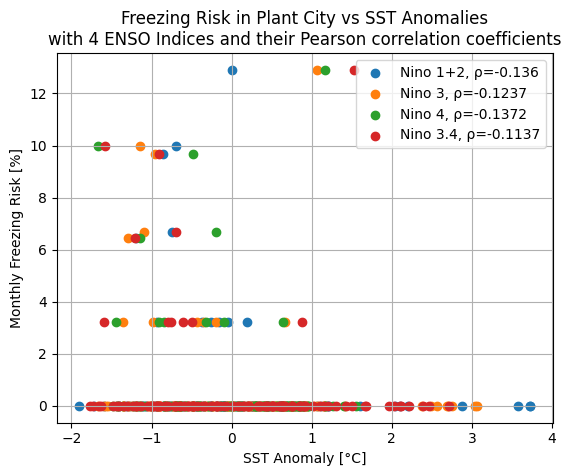

In [92]:
# import Pearson correlation test
from scipy.stats import pearsonr

# print final answer
print('Nino 4 index has the highest absolute Pearson correlation coefficient with the Plant City freezing risk during the months of Oct-Jan for 1991-2020')

# scatter plots of freezing risk for each month, year against SST anoms
# of each ENSO index
plt.figure()
plt.scatter(enso.groupby(['MON', 'YR']).mean('ANOM')['ANOM'],
            freeze_risk['monthly_freeze_risk']*100,
            label = 'Nino 1+2, ρ=' +\
            str(
                round(
                    pearsonr(enso.groupby(['MON', 'YR']).mean('ANOM')['ANOM'],freeze_risk['monthly_freeze_risk'])[0],
                    4))
            )
plt.scatter(enso.groupby(['MON', 'YR']).mean('ANOM')['ANOM.1'],
            freeze_risk['monthly_freeze_risk']*100,
            label = 'Nino 3, ρ=' +\
            str(
                round(
                    pearsonr(enso.groupby(['MON', 'YR']).mean('ANOM')['ANOM.1'],freeze_risk['monthly_freeze_risk'])[0],
                    4))
            )
plt.scatter(enso.groupby(['MON', 'YR']).mean('ANOM')['ANOM.2'],
            freeze_risk['monthly_freeze_risk']*100,
            label = 'Nino 4, ρ=' +\
            str(
                round(
                    pearsonr(enso.groupby(['MON', 'YR']).mean('ANOM')['ANOM.2'],freeze_risk['monthly_freeze_risk'])[0],
                    4))
            )
plt.scatter(enso.groupby(['MON', 'YR']).mean('ANOM')['ANOM.3'],
            freeze_risk['monthly_freeze_risk']*100,
            label = 'Nino 3.4, ρ=' +\
            str(
                round(
                    pearsonr(enso.groupby(['MON', 'YR']).mean('ANOM')['ANOM.3'],freeze_risk['monthly_freeze_risk'])[0],
                    4))
            )
plt.title('Freezing Risk in Plant City vs SST Anomalies\nwith 4 ENSO Indices and their Pearson correlation coefficients')
plt.ylabel('Monthly Freezing Risk [%]')
plt.xlabel('SST Anomaly [°C]')
plt.legend()
plt.grid()